### Generate PolygonLayer JSON

In [130]:
import numpy as np
import pandas as pd
import json

def point_to_tile(grid, threshold, dim):
    """
    Reshape an m*n*3 grid into (m-1)*(n-1) quadrilaterals.
    
    :param grid: numpy array of shape (m, n, 3)
    :return: list of quadrilaterals, where each quadrilateral is a 4*3 numpy array
    """
    m, n, _ = grid.shape
    quads = []
    preds = []
    
    for i in range(m - 1):
        for j in range(n - 1):
            if grid[i, j, 2] > threshold:
                quad = np.array([
                    grid[i, j, :dim],     # top-left
                    grid[i, j+1, :dim],   # top-right
                    grid[i+1, j+1, :dim],  # bottom-right
                    grid[i+1, j, :dim],   # bottom-left
                ])
                quads.append(quad)
                preds.append(grid[i, j, 2])
    print(len(preds))
    return quads,preds


def csv_to_point(csv_file_path):
    """
    Convert a CSV file to a NumPy array with added geographical coordinates.
    
    :param csv_file_path: Path to the input CSV file
    :param output_file_path: Path to save the output NumPy array
    :return: NumPy array of shape (m, n, 3)
    """
    # Read the CSV file
    df = pd.read_csv(csv_file_path, header=None)
    
    # Get the shape of the data
    m, n = df.shape
    
    # Create the base coordinates
    base_lon, base_lat = 147.1, -34.96
    
    # Create meshgrid for longitudes and latitudes
    lons = np.linspace(base_lon, base_lon + n*0.0015, num=n, endpoint=False)
    lats = np.linspace(base_lat, base_lat - m*0.0015, num=m, endpoint=False)  # Note the negative step for latitude
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    
    # Create the final 3D array
    result = np.zeros((m, n, 3))
    result[:,:,0] = lon_grid
    result[:,:,1] = lat_grid
    result[:,:,2] = df.values
    
    return result


def get_polygon_json(csv_file_path, json_file_path, threshold, mode='3d'):
    """
    Convert a CSV file to a JSON file with quadrilaterals.
    
    :param csv_file_path: Path to the input CSV file
    :param json_file_path: Path to save the output JSON file
    """
    # Convert CSV to NumPy array
    point_array = csv_to_point(csv_file_path)
    

    # Create the list of dictionaries for JSON
    json_data = []

    if mode == '3d':
        # Reshape to quadrilaterals
        quads, preds = point_to_tile(point_array, threshold, dim=3)

    else:
        quads, preds = point_to_tile(point_array, threshold, dim=2) 

    min_preds = min(preds)
    max_preds = max(preds)
    preds_normalized = [255 * (x - min_preds) / (max_preds - min_preds) for x in preds]
    for quad, pred in zip(quads, preds_normalized):
        json_data.append({
            "pred": pred, 
            "tile": quad.tolist()
        })
    
    # Write to JSON file
    with open(json_file_path, 'w') as f:
        json.dump(json_data, f, indent=2)
    
    print(f"JSON file has been saved to {json_file_path}")

### Generate ColumnLayer JSON

In [ ]:
import numpy as np
import pandas as pd
import json


def csv_to_point(csv_file_path):
    """
    Convert a CSV file to a NumPy array with added geographical coordinates.
    
    :param csv_file_path: Path to the input CSV file
    :param output_file_path: Path to save the output NumPy array
    :return: NumPy array of shape (m, n, 3)
    """
    # Read the CSV file
    df = pd.read_csv(csv_file_path, header=None)
    
    # Get the shape of the data
    m, n = df.shape
    
    # Create the base coordinates
    base_lon, base_lat = 147.1002, -34.96
    
    # Create meshgrid for longitudes and latitudes
    lons = np.linspace(base_lon, base_lon + n*0.006, num=n, endpoint=False)
    lats = np.linspace(base_lat, base_lat - m*0.006, num=m, endpoint=False)  # Note the negative step for latitude
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    
    # Create the final 3D array
    result = np.zeros((m, n, 3))
    result[:,:,0] = lon_grid
    result[:,:,1] = lat_grid
    result[:,:,2] = df.values
    
    return result


def get_column_json(csv_file_path, json_file_path):
    """
    Convert a CSV file to a JSON file with quadrilaterals.
    
    :param csv_file_path: Path to the input CSV file
    :param json_file_path: Path to save the output JSON file
    """

    # Convert CSV to NumPy array
    point_array = csv_to_point(csv_file_path)

    m, n, _ = point_array.shape

    # Create the list of dictionaries for JSON
    json_data = []

    
    for i in range(m):
        for j in range(n):
            json_data.append({
            "forecast": round(point_array[i, j, 2], 2), 
            "coordinates": [point_array[i, j, 0], point_array[i, j, 1]]
            })
        
    
    # Write to JSON file
    with open(json_file_path, 'w') as f:
        json.dump(json_data, f, indent=2)
    
    print(f"JSON file has been saved to {json_file_path}")

### Generate Random Data

In [138]:

# Set random seed for reproducibility
np.random.seed(42)

# Create a 400x200 grid
x = np.linspace(-10, 10, 524)
y = np.linspace(-10, 10, 232)
X, Y = np.meshgrid(x, y)

# Function to generate a single mountain peak
def generate_peak(x, y, height, width):
    return height * np.exp(-((X - x)**2 + (Y - y)**2) / width)

# Generate elevation data for 5 mountain peaks
Z = np.zeros(X.shape)
for _ in range(20):
    # Random position for each peak
    peak_x = np.random.uniform(-8, 8)
    peak_y = np.random.uniform(-8, 8)
    # Random height and width for each peak
    peak_height = np.random.uniform(800, 3200)
    peak_width = np.random.uniform(2, 6)
    
    Z += generate_peak(peak_x, peak_y, peak_height, peak_width)

# Add some random noise for terrain variation
# Z += np.random.normal(0, 1, X.shape)


# Create a DataFrame
df = pd.DataFrame(Z)

# Save to CSV
df.to_csv("data/rain_forecast.csv", index=False, header=False)

print("CSV file has been created.")

CSV file has been created.


In [139]:
# Example usage
csv_file_path = 'data/rain_forecast.csv'
json_file_path = 'data/rain_forecast.polygon.json'

get_polygon_json(csv_file_path, json_file_path, 0, mode='3d')
# get_polygon_json(csv_file_path, json_file_path)

120813
JSON file has been saved to data/rain_forecast.polygon.json


### Generate Contour Matplotlib

In [4]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.cm as cm

delta = 0.5
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2

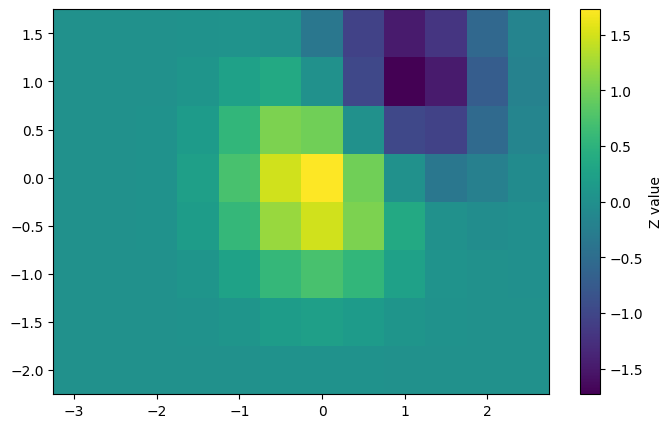

In [5]:
plt.figure(figsize=(8, 5))
plt.pcolormesh(X, Y, Z, shading='auto', cmap='viridis')
plt.colorbar(label='Z value')

# 显示图表
plt.show()

Text(0.5, 1.0, 'Simplest default with labels')

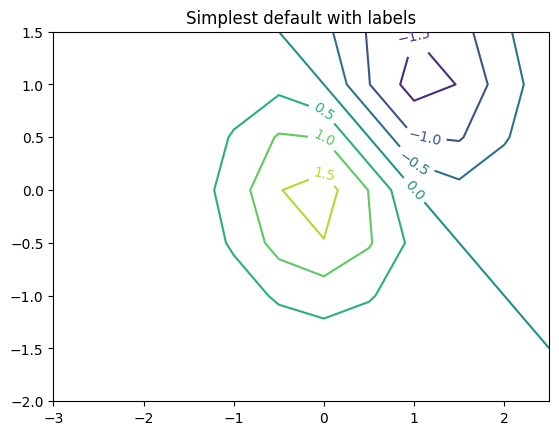

In [6]:
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Simplest default with labels')

### Generate Gaussion with Provided Centers

In [2]:
import numpy as np

def create_multi_gaussian_grid(centers, grid_size=100):
    """
    在grid_size * grid_size的网格中生成多个高斯分布并叠加
    
    参数:
    centers: list of tuples, 每个高斯分布的中心坐标和高斯分布的标准差 [(x1,y1,width), (x2,y2,width), ...]
    grid_size: int, 网格大小
    
    返回:
    numpy array: grid_size * grid_size的数组，包含叠加后的高斯分布值
    """
    # 创建网格坐标
    x = np.linspace(0, grid_size-1, grid_size)
    y = np.linspace(0, grid_size-1, grid_size)
    X, Y = np.meshgrid(x, y)
    
    # 初始化结果数组
    result = np.zeros((grid_size, grid_size))
    
    # 为每个中心点生成高斯分布并叠加
    for center in centers:
        # 计算到中心点的距离的平方
        dist_sq = (X - center[0])**2 + (Y - center[1])**2
        
        # 计算高斯分布值
        # 使用exp(-dist_sq/(2*width^2))确保在中心点处值为100，远离中心点处渐变至0
        gaussian = 100 * np.exp(-dist_sq / (2 * center[2]**2))
        
        # 叠加到结果数组
        result += gaussian

    max_num = result.max() 
    result = result / max_num * 128
    # 将结果四舍五入为整数
    result = np.round(result).astype(int)
    
    return result


6562
128


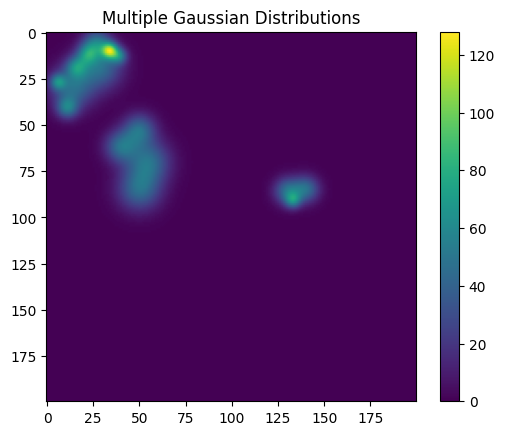

In [111]:
grid_size = 200
centers = [
        (34, 10, 3),(34, 10, 3),(27, 6, 5),(22, 12, 4),(39, 13, 3),
        (16, 19, 4), (6, 27, 3), (11, 41, 4), (14, 30, 8), (29, 19, 8),
        (50, 53, 6), (40, 62, 6), (55, 70, 8), (50, 85, 8), 
        (130, 86, 5),  (133, 91, 3), (140, 85, 5)
    ]
    
heatmap = create_multi_gaussian_grid(centers, grid_size=grid_size)
print((heatmap > 0).sum())
print(heatmap.max())

import matplotlib.pyplot as plt

plt.imshow(heatmap, cmap='viridis')
plt.colorbar()
plt.title('Multiple Gaussian Distributions')
plt.show()

# Generate Heatmap Data

In [4]:
import numpy as np
import pandas as pd
import json


def heatmap_to_point(heatmap, base_lon, base_lat, step):
    """
    Convert a CSV file to a NumPy array with added geographical coordinates.
    
    :param csv_file_path: Path to the input CSV file
    :param output_file_path: Path to save the output NumPy array
    :return: NumPy array of shape (m, n, 3)
    """
    
    # Get the shape of the data
    m, n = heatmap.shape
    
    # Create the base coordinates
    base_lon, base_lat = base_lon, base_lat
    
    # Create meshgrid for longitudes and latitudes
    lons = np.linspace(base_lon, base_lon + n*step, num=n, endpoint=False)
    lats = np.linspace(base_lat, base_lat - m*step, num=m, endpoint=False)  # Note the negative step for latitude
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    
    # Create the final 3D array
    result = np.zeros((m, n, 3))
    result[:,:,0] = lon_grid
    result[:,:,1] = lat_grid
    result[:,:,2] = heatmap
    
    return result


def get_heatmap_geojson(heatmap, base_lon, base_lat, step, json_file_path):
    """
    Convert a CSV file to a JSON file with quadrilaterals.
    
    :param csv_file_path: Path to the input CSV file
    :param json_file_path: Path to save the output JSON file
    """

    # Convert CSV to NumPy array
    point_array = heatmap_to_point(heatmap, base_lon, base_lat, step)

    m, n, _ = point_array.shape

    # Create the list of dictionaries for JSON
    json_data = []

    
    for i in range(m):
        for j in range(n):
            if point_array[i, j, 2] > 0:
                json_data.append({
                "risk": point_array[i, j, 2], 
                "coordinates": [point_array[i, j, 0], point_array[i, j, 1]]
                })

    geojson = {
        "type": "FeatureCollection",
        "features": [
            {
                "type": "Feature",
                "properties": {
                    "risk": point["risk"]
                },
                "geometry": {
                    "type": "Point",
                    "coordinates": point["coordinates"]
                }
            }
            for point in json_data
        ]
    }

        
    
    # Write to JSON file
    with open(json_file_path, 'w') as f:
        json.dump(geojson, f, indent=2)
    
    print(f"JSON file has been saved to {json_file_path}")

In [112]:
# Example usage
base_lon = 147.355
base_lat = -35.09
step = 0.0003
json_file_path = 'data/flood_heatmap.geo.json'

# get_polygon_json(csv_file_path, json_file_path, 0, mode='2d')
get_heatmap_geojson(heatmap, base_lon, base_lat, step, json_file_path)

JSON file has been saved to data/flood_heatmap.geo.json
